In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import glob

In [2]:
data = []
for path in sorted(glob.glob('/kaggle/input/llmpr-pair/ot_and_rp_and_rt_*.parquet')):
    df = pd.read_parquet(path)
    data.append(df)

In [3]:
data = pd.concat(data, ignore_index=True)

In [4]:
data2 = []
for path in sorted(glob.glob('/kaggle/input/llmpr-pair/1*.csv')):
    df = pd.read_csv(path)
    data2.append(df)

In [5]:
data2 = pd.concat(data2, ignore_index=True)

In [6]:
data2 = data2.drop(columns=['prompt', 'id'])

In [7]:
data2 = data2.dropna(subset=['rewritten_text']).reset_index(drop=True)

In [8]:
data2

,text,words,source,rewrite_prompt,original_text,rewritten_text
0,Celebrate the season of giving with iTworld 12...,63,advertisementText,Rewrite the paragraph to highlight Max's altr...,Celebrate the season of giving with iTworld 12...,"Sure, here is the rewritten paragraph with the..."
1,@user damn it! I was gonna see if you wanted t...,19,tweet,Rewrite the text as a letter from a time trav...,@user damn it! I was gonna see if you wanted t...,"Sure, here is the rewritten text as a letter f..."
2,"Date: Thu, 31 May 2001 06:55:53 -0700 (PDT)\nF...",158,email,"Present the text as a timeless mantra, to be ...","Date: Thu, 31 May 2001 06:55:53 -0700 (PDT)\nF...","Sure, here is the text presented as a timeless..."
3,Image copyright Thinkstock Image caption Domes...,452,openwebtext,"""As the winds howled through the city streets...",Image copyright Thinkstock Image caption Domes...,## Summary of the text:\n\nThis text describes...
4,"Hip Hop with Ms. Jen, I don't know why I say t...",139,blog_authorship_corpus,Can you transform this text into a futuristic...,"Hip Hop with Ms. Jen, I don't know why I say t...","Sure, here is the text transformed into a futu..."
...,...,...,...,...,...,...
18600,My friend recently gave me a book for my birth...,379,blog_authorship_corpus,Transform this peaceful scene into a thrillin...,My friend recently gave me a book for my birth...,"Sure, here's the transformed text into a thril..."
18601,"Date: Wed, 9 Aug 2000 07:25:00 -0700 (PDT)\nFr...",60,email,Turn this text into a series of social media ...,"Date: Wed, 9 Aug 2000 07:25:00 -0700 (PDT)\nFr...","**Post 1:**\n\n""Need two new books ASAP! 📚 FT-..."
18602,you only hide ~something for kate~ so i ke...,347,blog_authorship_corpus,Craft a set of whimsical fairy tale narrative...,you only hide ~something for kate~ so i ke...,## The Whispering Walls and The Hidden Flower\...
18603,‘He was a slob. Did you ever see him eat? Star...,285,openwebtext,Create a word cloud based on the most frequen...,‘He was a slob. Did you ever see him eat? Star...,"Sure, here is a word cloud based on the text:\..."


In [9]:
data = pd.concat([data, data2], ignore_index=True)

In [10]:
sft = pd.read_csv('/kaggle/input/llmpr-pair/sft_train_merge.csv')

In [11]:
sft['rewritten_text'] = sft['rewritten_text'].str.strip()

In [12]:
pub = pd.read_parquet('/kaggle/input/llmpr-public-data-fix/train_pub.parquet')

In [13]:
data = pd.concat([data[['original_text', 'rewritten_text', 'rewrite_prompt']], sft, pub], ignore_index=True)

In [14]:
import re

def fix_prompt(text):
    patterns = [
        r'therefore.*I cannot',
        "does not contain any",
        'am unable to provide',
        "am unable to rewrite",
        "do not have the capacity to write",
        "am unable to engage",
        "I am unable to",
        "not provide information",
    ]
    sub_patterns= [
        r"Sure, here.*?:",
        r"Sure. here.*?:",
        r"Certainly, here.*?:",
        r"here.*? text*?:",
        r"Summary of .*?\n\n",
        r"Analysis of .*?\n\n",
        #r"The text.*?:"
    ]
    for p in patterns:
        match = re.search(p, text, re.IGNORECASE)
        
        if match:
            text = ''
    
    if text=="":
        return text
    else:
        for p in sub_patterns:
            match = re.search(p, text, re.IGNORECASE)
            if match:
                text = text[match.end():]
        if text.startswith('**\n\n') or text.startswith('user'):
            text=text[4:].strip()
        return text

In [15]:
clean_texts = []
for i,row in tqdm(data.iterrows(), total=len(data)):
    text = row['rewritten_text']
    fix_text = fix_prompt(text)
    clean_texts.append(fix_text)

  0%|          | 0/531565 [00:00<?, ?it/s]

In [16]:
data['clean_text'] = clean_texts
data['text_len'] = data['clean_text'].map(lambda x:len(x.split(' ')))
data = data[data['text_len']>4].reset_index(drop=True)
data['clean_text'] = data['clean_text'].map(lambda x:re.sub(r"The text.*?\n\n", '', x) if x.startswith('The text you') else x)

In [17]:
supple = pd.read_csv('/kaggle/input/supplementary-texts-rewritten-by-genai-models/test.csv')

<Axes: >

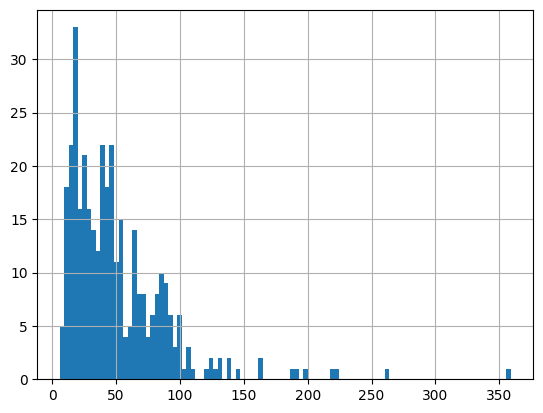

In [18]:
supple['rewritten_text'].map(lambda x:len(x.split(' '))).hist(bins=100)

In [19]:
data = data[~data['clean_text'].str.contains(r'Original Text')].reset_index(drop=True)

In [20]:
data['clean_text'] = data['clean_text'].map(lambda x:str(x).replace('*', '').replace('#', '').strip())

In [21]:
data['text_len'] = data['clean_text'].map(lambda x:len(x.split(' ')))

In [22]:
data['flag'] = data['clean_text'].map(lambda x:1 if re.search(r'[a-zA-Z]$', x) else 0)

In [23]:
data = data[(data['flag']==0) | (data['text_len']>32)].reset_index(drop=True)

In [24]:
supple[['original_text', 'rewritten_text']].sample(20).values

array([['In the small town of Willowbrook, Patsy discovered a hidden book in her attic. As she read the ancient pages, she learned about a mystical necklace that granted eternal life. Determined to find it, Patsy embarked on a journey through treacherous forests and dark caves. Finally, she reached the secret chamber where the necklace lay. With trembling hands, she placed it around her neck, feeling the weight of eternity settle upon her shoulders.',
        'In the peaceful town of Willowbrook, Patsy stumbled upon a hidden book in her attic. As she delved into its ancient pages, she uncovered the tale of a mystical necklace that bestowed eternal life. Inspired by the story, Patsy set out on a journey through enchanting forests and mysterious caves. After much perseverance, she arrived at a hidden chamber where the necklace awaited. With a sense of awe, Patsy gently placed it around her neck, embracing the timeless bond it offered.'],
       ["Hey Maria! Just wanted to let you know th

In [25]:
data[['original_text', 'clean_text']].sample(20).values

array([['Excavata Many of the protist species classified into the supergroup Excavata are asymmetrical, single-celled organisms with a feeding groove “excavated” from one side. This supergroup includes heterotrophic predators, photosynthetic species, and parasites. Its subgroups are the diplomonads, parabasalids, and euglenozoans. Diplomonads Among the Excavata are the diplomonads, which include the intestinal parasite, Giardia lamblia (Figure 23.10). Until recently, these protists were believed to lack mitochondria. Mitochondrial remnant organelles, called mitosomes, have since been identified in diplomonads, but these mitosomes are essentially nonfunctional. Diplomonads exist in anaerobic environments and use alternative pathways, such as glycolysis, to generate energy. Each diplomonad cell has two identical nuclei and uses several flagella for locomotion.',
        'Excavate protists of the supergroup Excavata include asymmetrical, single-celled organisms that have a feeding groove 

In [26]:
data['rewritten_text'] = data['clean_text']

In [27]:
data = data.dropna(subset=['rewrite_prompt']).reset_index(drop=True)

In [28]:
data['rewrite_prompt'] = data['rewrite_prompt'].map(lambda x:x.strip())

In [29]:
data[['original_text', 'rewrite_prompt', 'rewritten_text',]].to_parquet('train_clean.parquet')

In [30]:
#data[['original_text', 'rewrite_prompt', 'rewritten_text',]].to_csv('train_clean.csv', index=False)

In [31]:
data['original_text']

0         The greater New Orleans area--Jefferson, Orlea...
1         Your dryer can do more than what you think it ...
2         ‘Notorious B.I.G.’ Name and Likeness Rights So...
3         my acronym      J     Joyful       I     Influ...
4         Date: Wed, 19 Jul 2000 06:15:00 -0700 (PDT)\nF...
                                ...                        
421817    Dick Marlow, a British agent, has parachuted i...
421818    India is plagued with kidnappings of young chi...
421819    The movie is about two high school dropouts, M...
421820    The film follows the life of three former stud...
421821    Jhumroo, a tribal, falls in love with Anjana, ...
Name: original_text, Length: 421822, dtype: object

In [32]:
data['rewrite_prompt'].nunique()

149856